In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import entropy
from urllib.parse import urlparse

In [18]:

dateparse = lambda x: pd.to_datetime(x, format="%Y-%m-%d %H:%M:%S%z")  # pd.datetime.strptime

# all_users = pd.read_csv('../data/all_users.csv')
# users_activities = pd.read_csv('../data/users_activity.csv')
# sample_tweets = pd.read_csv('../data/sample_tweets.csv')


users = pd.read_csv("../data/all_users.csv",
                    parse_dates=['created_at'],
                    converters={"user_id": str})
tweets = pd.read_csv("../data/sample_tweets.csv", #path/to/tweets_file
                     # nrows = 400000,
                     parse_dates=['created_at'],
                     converters={"user_id": str,
                                 "tweet_id": str},
                     date_parser=dateparse,
                     lineterminator='\n')
activity = pd.read_csv("../data/users_activity.csv", #path/to/activity_file/
                       converters={"user_id": str})

core_users_ids = pd.read_csv("../data/core_users.csv",
                             converters={"user_id": str})


# Filtra il dataframe per includere solo le righe in cui l'user_id è presente nella lista dei core users
core_users = users[users["user_id"].isin(core_users_ids["user_id"])]

# Filtra i tweet degli utenti core
core_users_tweets = tweets[tweets['user_id'].isin(core_users['user_id'])]


C:\Users\davis\AppData\Local\Temp\ipykernel_2288\659142548.py:8: DtypeWarning: Columns (2,3,9,10,11,12) have mixed types. Specify dtype option on import or set low_memory=False.
  users = pd.read_csv("../data/all_users.csv",
C:\Users\davis\AppData\Local\Temp\ipykernel_2288\659142548.py:11: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  tweets = pd.read_csv("../data/sample_tweets.csv", #path/to/tweets_file


In [19]:
core_users.set_index('user_id', inplace=True)

core_users_credibility = core_users.copy()
core_users_initiative = core_users.copy()
core_users_adaptability = core_users.copy()

core_users_to_cluster = core_users.copy()


core_users.head()
# activity.head()
# tweets.head()

,created_at,user_screen_name,name,nbr_followers,nbr_followings,nbr_liked_tweets,nbr_lists,nbr_tweets,verified,protected,location,description,nbr_accounts,nbr_usernames
user_id,,,,,,,,,,,,,,
841318992094605313,2017-03-13 16:04:13+00:00,dg080310,Donato G.🇮🇹#ICEUTNE#,210.0,486.0,49.0,0.0,3.0,False,False,NaN,Monza Lombardia 🏎 ...,1.0,2.0
1218242063638188033,2020-01-17 18:42:36+00:00,Fidelio16852684,Fidelio,0.0,0.0,97.0,0.0,8.0,False,False,NaN,NaN,1.0,1.0
1311952044144685056,2020-10-02 08:52:58+00:00,IlS0vran,ilS0vranIsta,36.0,35.0,1.0,1.0,17.0,False,False,NaN,NaN,1.0,1.0
52021947,2009-06-29 10:46:16+00:00,marcobobabo,Marco D'Addabbo,10.0,167.0,368.0,0.0,24.0,False,False,"Milano, Lombardia",puglioemilianmilanestesista. il dottor house è...,1.0,1.0
1298360422433730560,2020-08-25 20:43:52+00:00,Sararisso3,APOCALYPTO. IL SONNO DELLA RAGIONE GENERA MOSTRI.,46.0,25.0,0.0,0.0,52.0,False,False,NaN,"Raga, bro, con la 3° guerra mondiale possiamo ...",1.0,1.0


## Credibility

### Friends count (Number of followings)

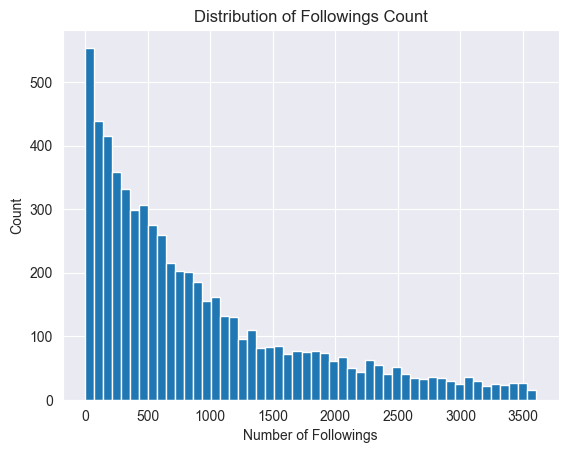

In [20]:
plt.hist(core_users['nbr_followings'], bins=50, range=(0, core_users['nbr_followings'].quantile(0.90)))
plt.xlabel('Number of Followings')
plt.ylabel('Count')
plt.title('Distribution of Followings Count')
plt.show()

### Followers count

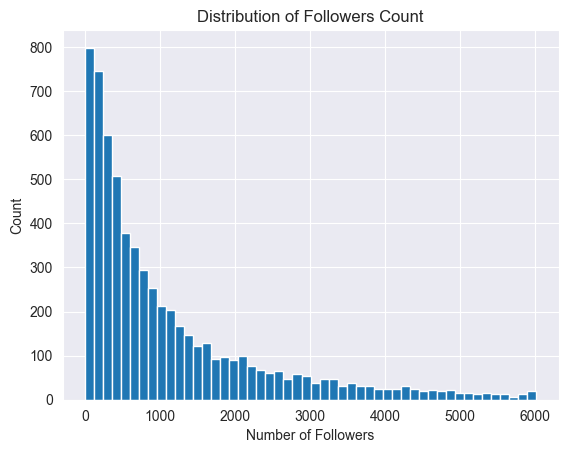

In [21]:
#core_users_copy['log_followers'] = np.log10(core_users_copy['nbr_followers'] + 1)

plt.hist(core_users['nbr_followers'], bins=50, range=(0, core_users['nbr_followers'].quantile(0.90)))
plt.xlabel('Number of Followers')
plt.ylabel('Count')
plt.title('Distribution of Followers Count')
plt.show()

### Favorites Ratio

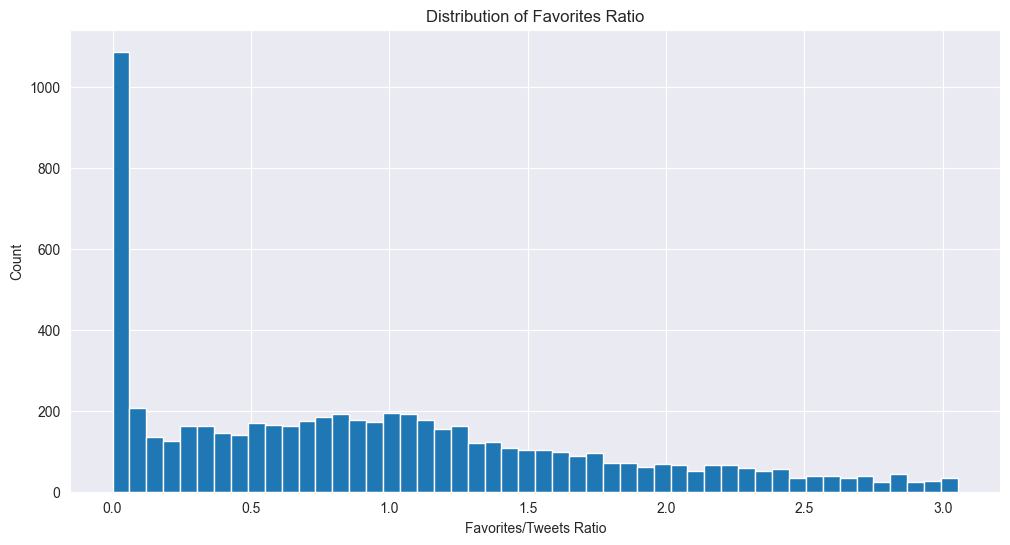

In [22]:
# core_users_credibility = core_users.copy()

core_users_credibility['favorites_ratio'] = core_users_credibility['nbr_liked_tweets'] / core_users_credibility['nbr_tweets'].replace(0, np.nan)

plt.figure(figsize=(12, 6))

plt.hist(core_users_credibility['favorites_ratio'].dropna(), bins=50, range=(0, core_users_credibility['favorites_ratio'].quantile(0.90)))
plt.xlabel('Favorites/Tweets Ratio')
plt.ylabel('Count')
plt.title('Distribution of Favorites Ratio')
plt.show()


core_users_to_cluster['favorites_ratio'] = core_users_credibility['favorites_ratio']

### Followers Ratio

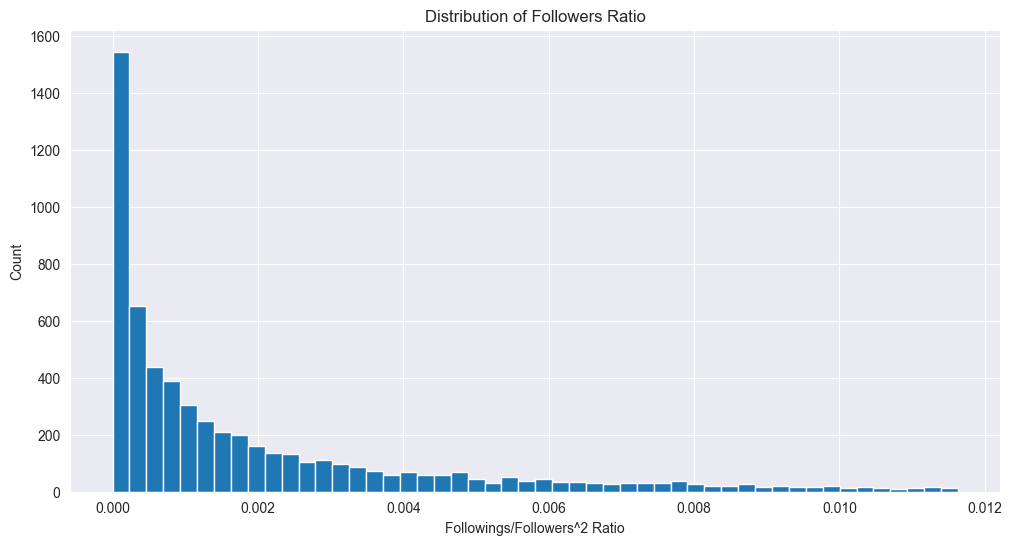

In [23]:
core_users_credibility = core_users.copy()

core_users_credibility['followers_ratio'] = core_users_credibility['nbr_followings'] / (core_users_credibility['nbr_followers']**2 + 1)

plt.figure(figsize=(12, 6))

plt.hist(core_users_credibility['followers_ratio'].dropna(), bins=50, range=(0, core_users_credibility['followers_ratio'].quantile(0.85)))
plt.xlabel('Followings/Followers^2 Ratio')
plt.ylabel('Count')
plt.title('Distribution of Followers Ratio')
plt.show()


core_users_to_cluster['followers_ratio'] = core_users_credibility['followers_ratio']

### Has URL

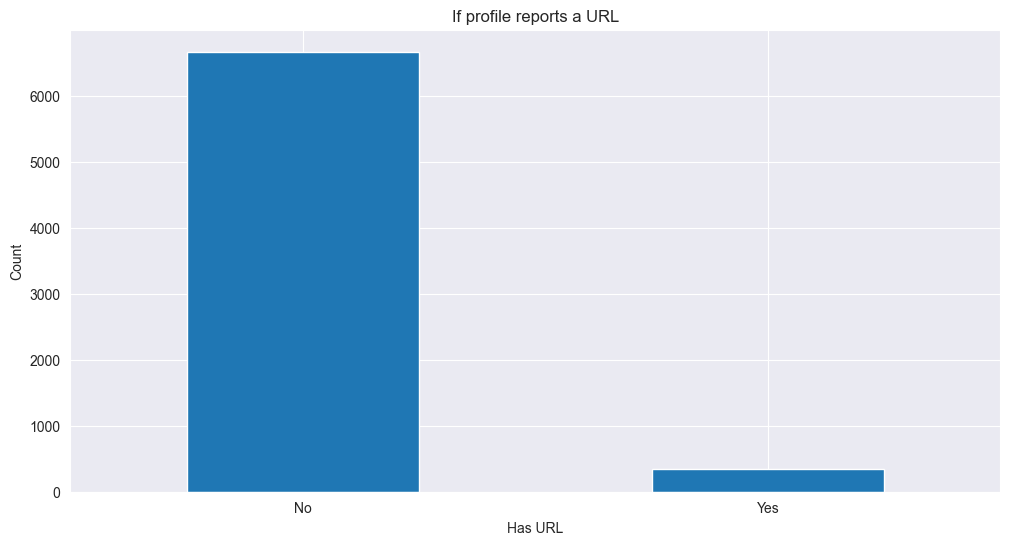

In [24]:
core_users_credibility = core_users.copy()

core_users_credibility['has_url'] = core_users_credibility['description'].fillna('').str.contains('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')

plt.figure(figsize=(12, 6))

core_users_credibility['has_url'].value_counts().plot(kind='bar')

plt.xlabel('Has URL')
plt.ylabel('Count')
plt.title('If profile reports a URL')
plt.xticks([0, 1], ['No', 'Yes'], rotation=0)  # replaces 0 and 1 with 'No' and 'Yes'
plt.show()


core_users_to_cluster['has_url'] = core_users_credibility['has_url']

### Bio sentences

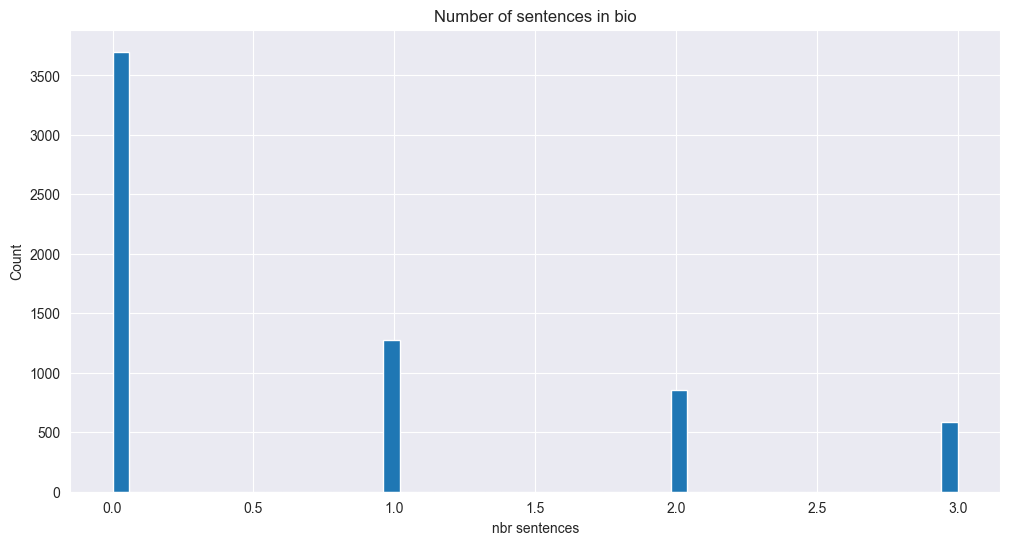

In [25]:
core_users_credibility = core_users.copy()

core_users_credibility['bio_sentences'] = core_users_credibility['description'].fillna('').str.count('\.')

plt.figure(figsize=(12, 6))

plt.hist(core_users_credibility['bio_sentences'].dropna(), bins=50, range=(0, core_users_credibility['bio_sentences'].quantile(0.85)))
plt.xlabel('nbr sentences')
plt.ylabel('Count')
plt.title('Number of sentences in bio')
plt.show()


core_users_to_cluster['bio_sentences'] = core_users_credibility['bio_sentences']

### Bio tokens

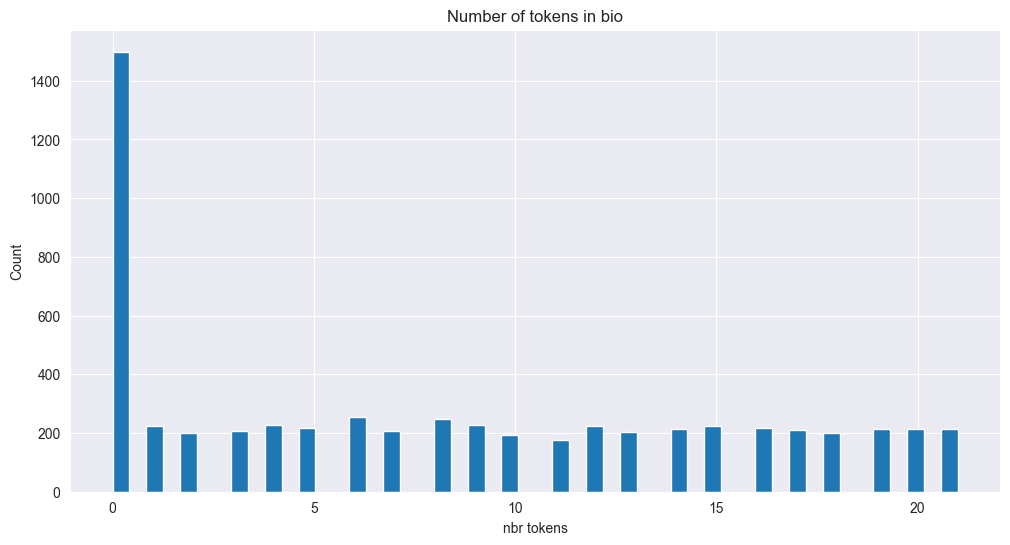

In [26]:
core_users_credibility = core_users.copy()

# Rimuove le righe con 'description' vuoto, quindi i retweet
# core_users_credibility = core_users_credibility.dropna(subset=['description'])

core_users_credibility['bio_tokens'] = core_users_credibility['description'].fillna('').str.split().str.len()

plt.figure(figsize=(12, 6))

plt.hist(core_users_credibility['bio_tokens'].dropna(), bins=50, range=(0, core_users_credibility['bio_tokens'].quantile(0.85)))
plt.xlabel('nbr tokens')
plt.ylabel('Count')
plt.title('Number of tokens in bio')
plt.show()


core_users_to_cluster['bio_tokens'] = core_users_credibility['bio_tokens']

### Bio characters

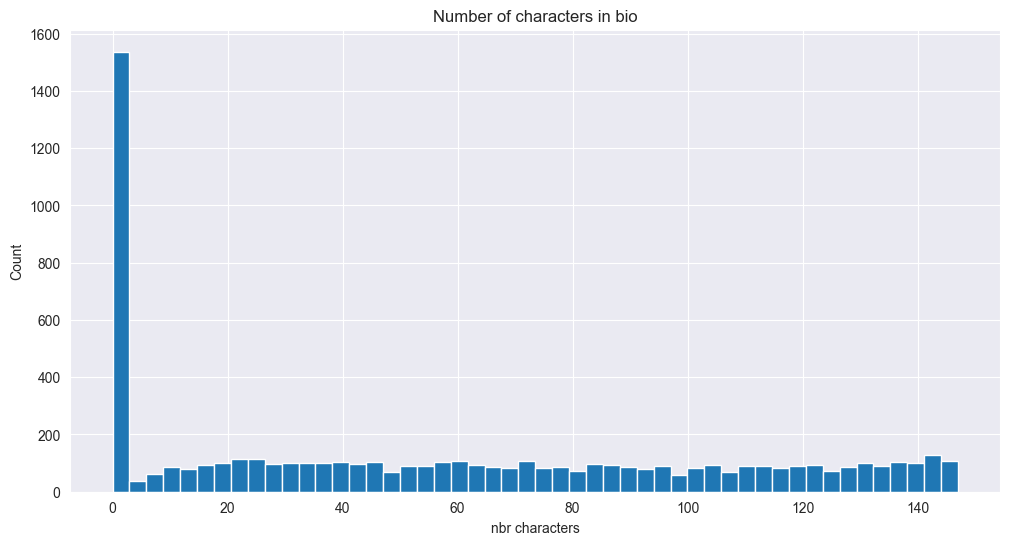

In [27]:
core_users_credibility = core_users.copy()

# Rimuove le righe con 'description' vuoto, quindi i retweet
# core_users_credibility = core_users_credibility.dropna(subset=['description'])

core_users_credibility['bio_characters'] = core_users_credibility['description'].fillna('').str.len()

plt.figure(figsize=(12, 6))

plt.hist(core_users_credibility['bio_characters'].dropna(), bins=50, range=(0, core_users_credibility['bio_characters'].quantile(0.85)))
plt.xlabel('nbr characters')
plt.ylabel('Count')
plt.title('Number of characters in bio')
plt.show()


core_users_to_cluster['bio_characters'] = core_users_credibility['bio_characters']

### Has bio

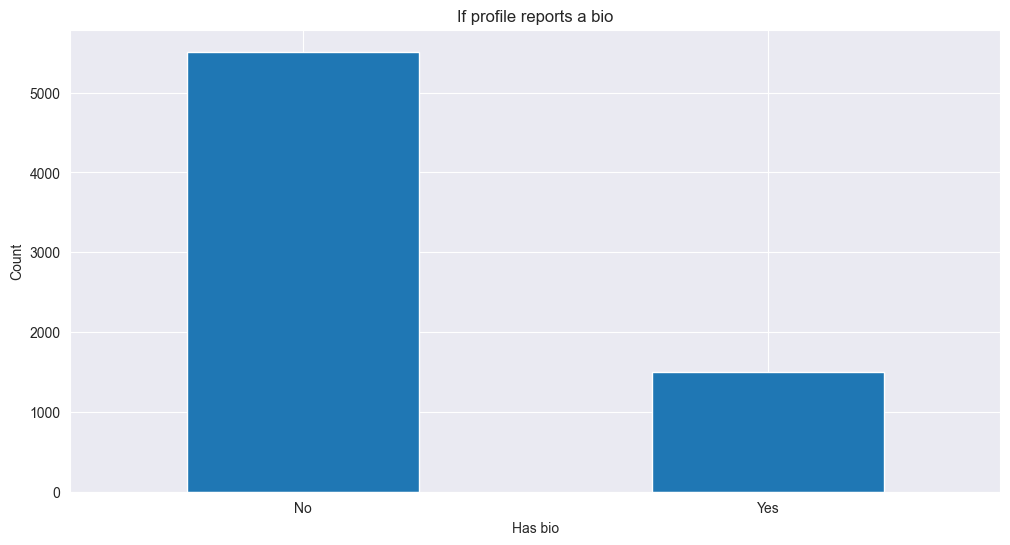

In [28]:
core_users_credibility = core_users.copy()

core_users_credibility['has_bio'] = core_users_credibility['description'].fillna('').str.len() > 0

plt.figure(figsize=(12, 6))

core_users_credibility['has_bio'].value_counts().plot(kind='bar')

plt.xlabel('Has bio')
plt.ylabel('Count')
plt.title('If profile reports a bio')
plt.xticks([0, 1], ['No', 'Yes'], rotation=0)  # replaces 0 and 1 with 'No' and 'Yes'
plt.show()


core_users_to_cluster['has_bio'] = core_users_credibility['has_bio']

### Account age

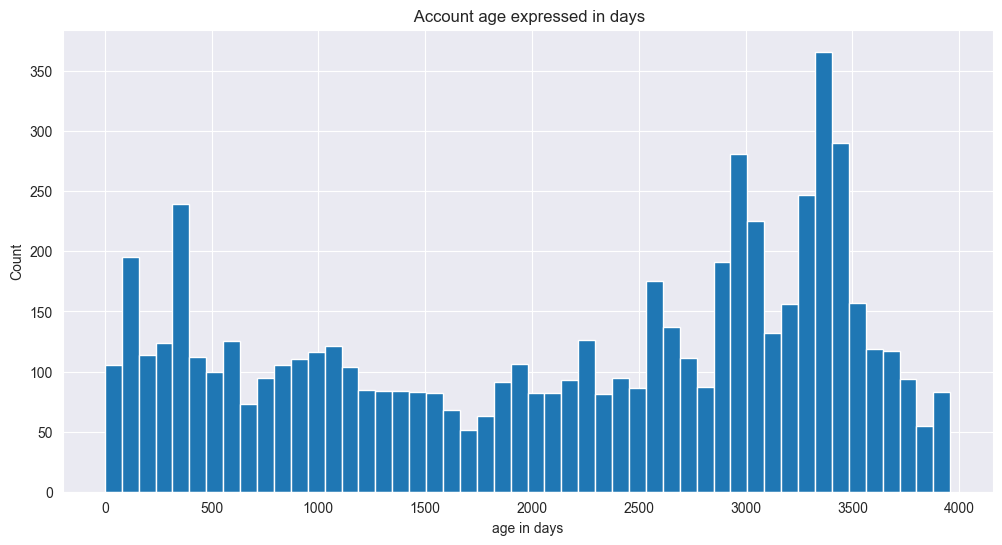

In [29]:
core_users_credibility = core_users.copy()

core_users_credibility['created_at'] = pd.to_datetime(core_users_credibility['created_at'])

# Find the date of the most recent tweet for each user
latest_tweets = tweets.groupby('user_id')['created_at'].max()

# Convert to DataFrame and do not reset index
latest_tweets = pd.DataFrame(latest_tweets)

# Merge core_users with latest_tweets using the indexes
core_users_credibility = core_users_credibility.merge(latest_tweets, left_index=True, right_index=True, how='left', suffixes=('_user', '_tweet'))

# Calculate account age in days
core_users_credibility['account_age'] = (core_users_credibility['created_at_tweet'] - core_users_credibility['created_at_user']).dt.days

plt.figure(figsize=(12, 6))

plt.hist(core_users_credibility['account_age'].replace([np.inf, -np.inf], np.nan).dropna(), bins=50, range=(0, core_users_credibility['account_age'].quantile(0.90)))
plt.xlabel('age in days')
plt.ylabel('Count')
plt.title(' Account age expressed in days')
plt.show()


core_users_to_cluster['account_age'] = core_users_credibility['account_age']

### Following Ratio

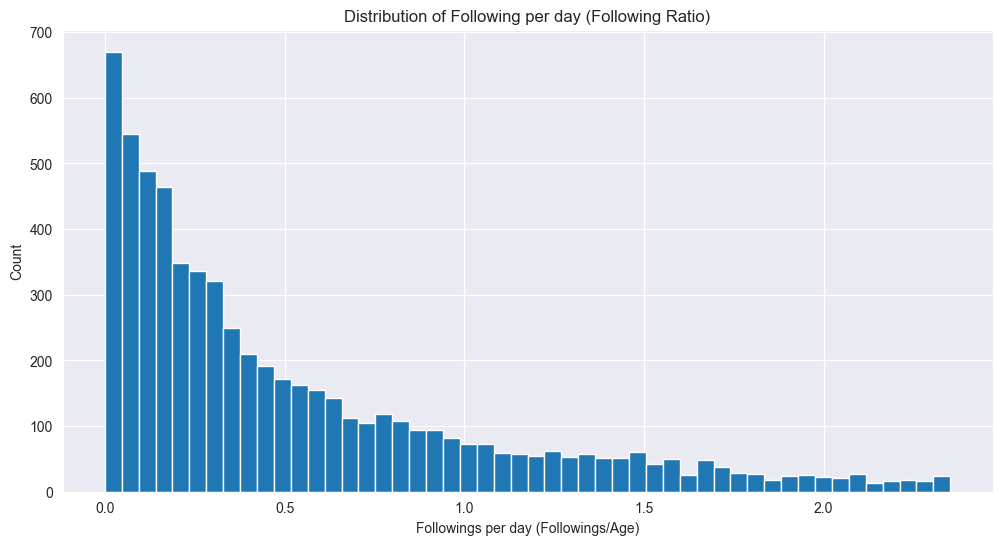

In [30]:
core_users_credibility = core_users.copy()

core_users_credibility['following_ratio'] = core_users_credibility['nbr_followings'] / (core_users_to_cluster['account_age'])

plt.figure(figsize=(12, 6))

plt.hist(core_users_credibility['following_ratio'].replace([np.inf, -np.inf], np.nan).dropna(), bins=50, range=(0, core_users_credibility['following_ratio'].quantile(0.90)))
plt.xlabel('Followings per day (Followings/Age)')
plt.ylabel('Count')
plt.title('Distribution of Following per day (Following Ratio)')
plt.show()


core_users_to_cluster['following_ratio'] = core_users_credibility['following_ratio']

### Tweet Ratio

C:\Users\davis\AppData\Local\Temp\ipykernel_2288\3542353117.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  core_users['created_at'] = pd.to_datetime(core_users['created_at'])


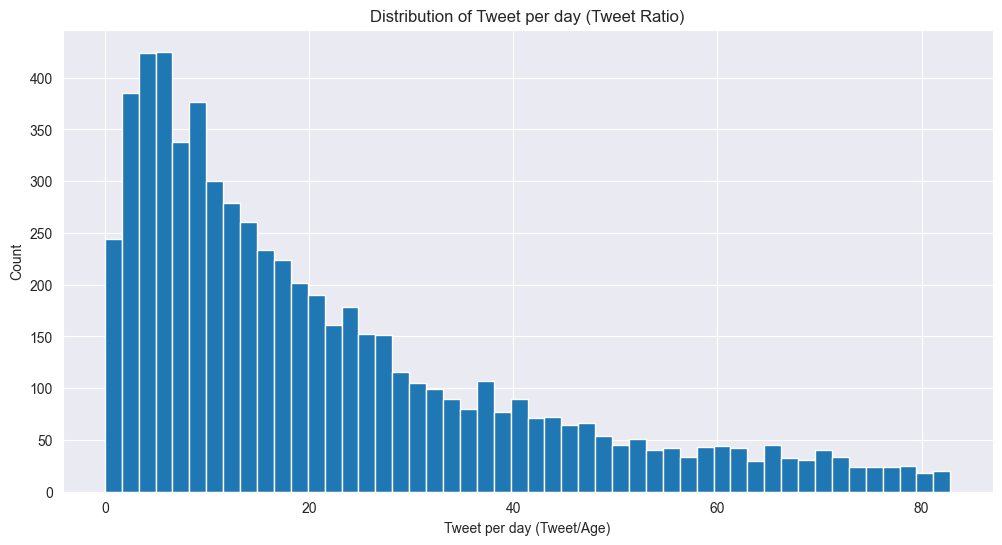

In [31]:
core_users_credibility = core_users.copy()

core_users['created_at'] = pd.to_datetime(core_users['created_at'])

core_users_credibility['tweet_ratio'] = core_users_credibility['nbr_tweets'] / (core_users_to_cluster['account_age'])

plt.figure(figsize=(12, 6))

plt.hist(core_users_credibility['tweet_ratio'].replace([np.inf, -np.inf], np.nan).dropna(), bins=50, range=(0, core_users_credibility['tweet_ratio'].quantile(0.90)))
plt.xlabel('Tweet per day (Tweet/Age)')
plt.ylabel('Count')
plt.title('Distribution of Tweet per day (Tweet Ratio)')
plt.show()


core_users_to_cluster['tweet_ratio'] = core_users_credibility['tweet_ratio']

## Initiative

### Retweet Ratio

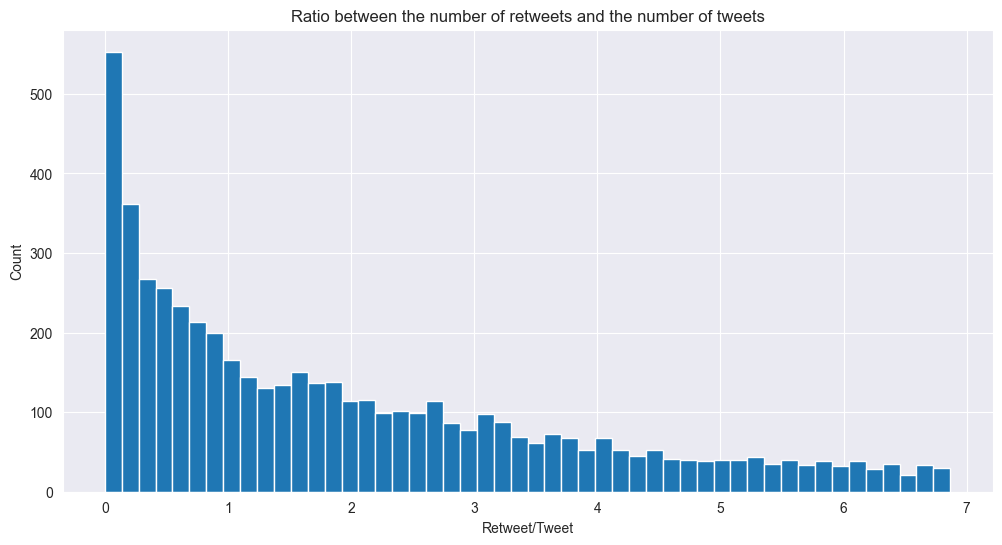

In [32]:
# core_users_initiative = core_users.copy()

# Numero di retweets effettuato da ogni utente

# Calcola il numero di retweets per ogni utente
retweets_count = core_users_tweets[core_users_tweets['is_retweet'] == 1]['user_id'].value_counts()

# Calcola il numero di tweets originali per ogni utente
original_tweets_count = core_users_tweets[core_users_tweets['is_retweet'] == 0]['user_id'].value_counts()


# Aggiunge le colonne 'nbr_retweet' e 'nbr_original_tweets' a core_users_initiative
core_users_initiative['nbr_retweet'] = core_users_initiative.index.map(retweets_count)
core_users_initiative['nbr_original_tweets'] = core_users_initiative.index.map(original_tweets_count)


# Calcola il retweet_ratio
core_users_initiative['retweet_ratio'] = core_users_initiative['nbr_retweet'] / core_users_initiative['nbr_original_tweets']


plt.figure(figsize=(12, 6))

plt.hist(core_users_initiative['retweet_ratio'].dropna(), bins=50, range=(0, core_users_initiative['retweet_ratio'].quantile(0.85)))
plt.xlabel('Retweet/Tweet')
plt.ylabel('Count')
plt.title('Ratio between the number of retweets and the number of tweets')
plt.show()


core_users_to_cluster['retweet_ratio'] = core_users_initiative['retweet_ratio']

### Reply Ratio

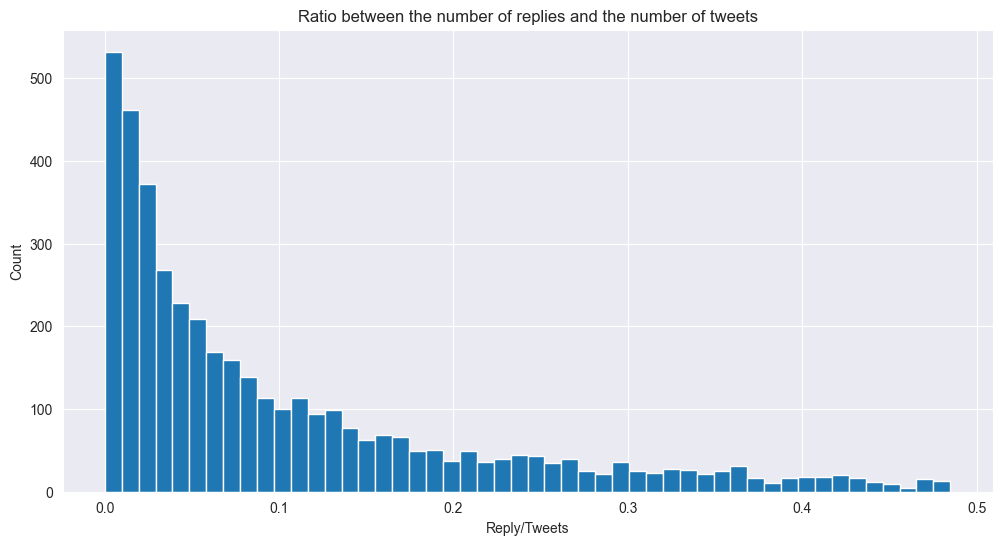

In [33]:
core_users_initiative = core_users.copy()

# Numero di risposte effettuate da ogni core_users

# Calcola il numero di retweets per ogni utente
replies_count = core_users_tweets[core_users_tweets['is_reply'] == 1]['user_id'].value_counts()

# Calcola il numero di tweets originali per ogni utente
no_replies_count = core_users_tweets[core_users_tweets['is_reply'] == 0]['user_id'].value_counts()


# Aggiunge le colonne 'nbr_retweet' e 'nbr_original_tweets' a core_users_initiative
core_users_initiative['nbr_reply'] = core_users_initiative.index.map(replies_count)
core_users_initiative['nbr_no_reply_tweets'] = core_users_initiative.index.map(no_replies_count)


# Calcola il retweet_ratio
core_users_initiative['reply_ratio'] = core_users_initiative['nbr_reply'] / core_users_initiative['nbr_no_reply_tweets']


plt.figure(figsize=(12, 6))

plt.hist(core_users_initiative['reply_ratio'].dropna(), bins=50, range=(0, core_users_initiative['reply_ratio'].quantile(0.85)))
plt.xlabel('Reply/Tweets')
plt.ylabel('Count')
plt.title('Ratio between the number of replies and the number of tweets')
plt.show()


core_users_to_cluster['reply_ratio'] = core_users_initiative['reply_ratio']

### Tweet-URL ratio

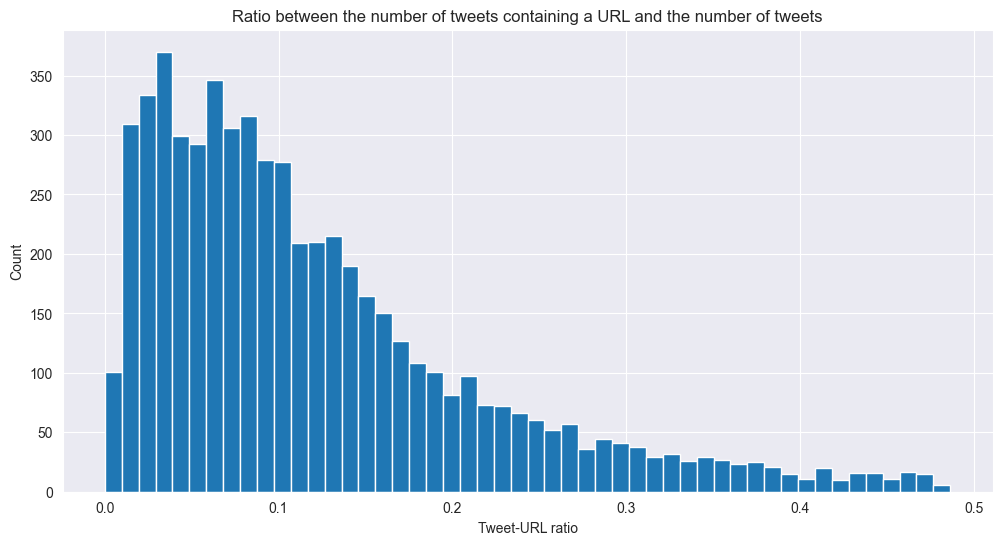

In [34]:
core_users_initiative = core_users.copy()

# Numero totale di tweet per utente
total_tweets_count = tweets['user_id'].value_counts()

# Numero di tweet che contengono un URL per utente
url_tweets_count = tweets[tweets['urls'].notnull()]['user_id'].value_counts()

# Aggiungi il conteggio totale dei tweet e il conteggio dei tweet con URL a core_users_initiative
core_users_initiative['total_tweets'] = core_users_initiative.index.map(total_tweets_count)
core_users_initiative['url_tweets'] = core_users_initiative.index.map(url_tweets_count)

# Calcola il Tweet-URL ratio
core_users_initiative['tweet_url_ratio'] = core_users_initiative['url_tweets'] / core_users_initiative['total_tweets']

# Stampa un istogramma del Tweet-URL ratio
plt.figure(figsize=(12, 6))
plt.hist(core_users_initiative['tweet_url_ratio'].dropna(), bins=50, range=(0, core_users_initiative['tweet_url_ratio'].quantile(0.85)))
plt.xlabel('Tweet-URL ratio')
plt.ylabel('Count')
plt.title('Ratio between the number of tweets containing a URL and the number of tweets')
plt.show()


# Aggiungi il Tweet-URL ratio a core_users_to_cluster
core_users_to_cluster['tweet_url_ratio'] = core_users_initiative['tweet_url_ratio']

### Retweet-URL ratio

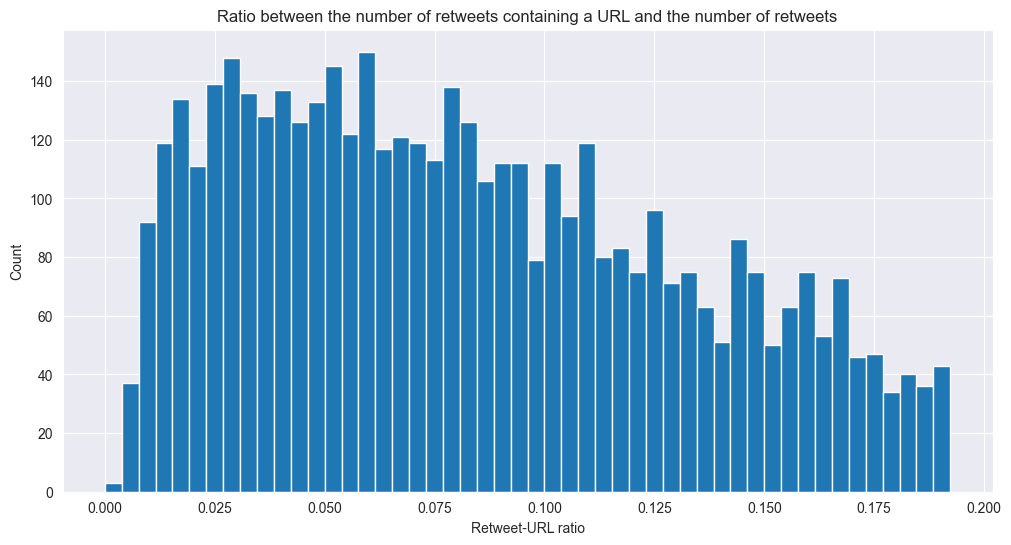

In [35]:
core_users_initiative = core_users.copy()

# Numero totale di retweet per utente
total_retweets_count = tweets[tweets['is_retweet'] == 1]['user_id'].value_counts()

# Numero di retweet che contengono un URL per utente
url_retweets_count = tweets[(tweets['urls'].notnull()) & (tweets['is_retweet'] == 1)]['user_id'].value_counts()

# Aggiungi il conteggio totale dei retweet e il conteggio dei retweet con URL a core_users_initiative
core_users_initiative['total_retweets'] = core_users_initiative.index.map(total_retweets_count)
core_users_initiative['url_retweets'] = core_users_initiative.index.map(url_retweets_count)

# Calcola il Retweet-URL ratio
core_users_initiative['retweet_url_ratio'] = core_users_initiative['url_retweets'] / core_users_initiative['total_retweets']

# Stampa un istogramma del Retweet-URL ratio
plt.figure(figsize=(12, 6))
plt.hist(core_users_initiative['retweet_url_ratio'].dropna(), bins=50, range=(0, core_users_initiative['retweet_url_ratio'].quantile(0.85)))
plt.xlabel('Retweet-URL ratio')
plt.ylabel('Count')
plt.title('Ratio between the number of retweets containing a URL and the number of retweets')
plt.show()


# Aggiungi il Retweet-URL ratio a core_users_to_cluster
core_users_to_cluster['retweet_url_ratio'] = core_users_initiative['retweet_url_ratio']

### Reply-URL ratio

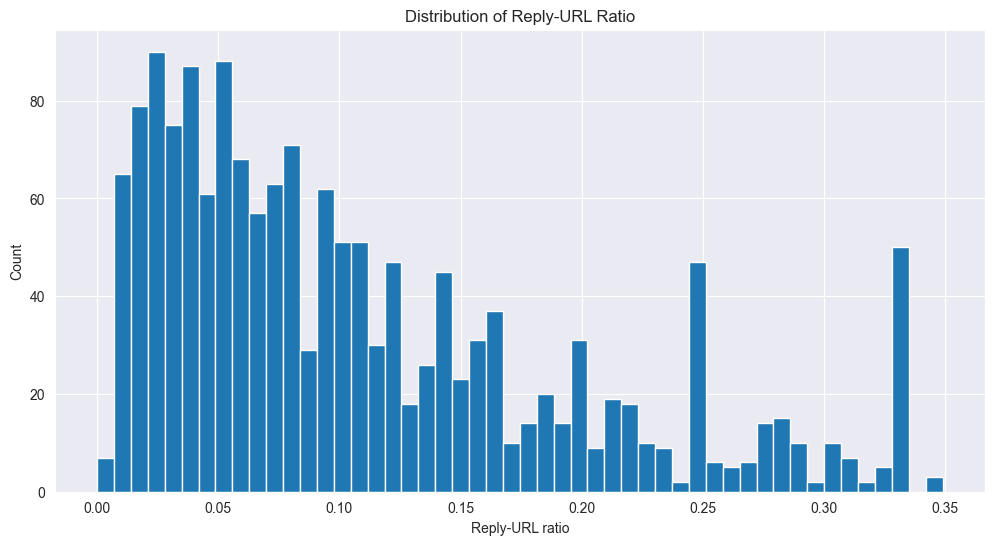

In [36]:
core_users_initiative = core_users.copy()

# Numero totale di replies per utente
total_replies_count = tweets[tweets['is_reply'] == 1]['user_id'].value_counts()

# Numero di replies che contengono un URL per utente
url_replies_count = tweets[(tweets['urls'].notnull()) & (tweets['is_reply'] == 1)]['user_id'].value_counts()

# Aggiungi il conteggio totale dei replies e il conteggio dei replies con URL a core_users_initiative
core_users_initiative['total_replies'] = core_users_initiative.index.map(total_replies_count)
core_users_initiative['url_replies'] = core_users_initiative.index.map(url_replies_count)

# Calcola il Reply-URL ratio
core_users_initiative['reply_url_ratio'] = core_users_initiative['url_replies'] / core_users_initiative['total_replies']

# Stampa un istogramma del Reply-URL ratio
plt.figure(figsize=(12, 6))
plt.hist(core_users_initiative['reply_url_ratio'].dropna(), bins=50, range=(0, core_users_initiative['reply_url_ratio'].quantile(0.85)))
plt.xlabel('Reply-URL ratio')
plt.ylabel('Count')
plt.title('Distribution of Reply-URL Ratio')
plt.show()


# Aggiungi il Reply-URL ratio a core_users_to_cluster
core_users_to_cluster['reply_url_ratio'] = core_users_initiative['reply_url_ratio']

### Words in tweets

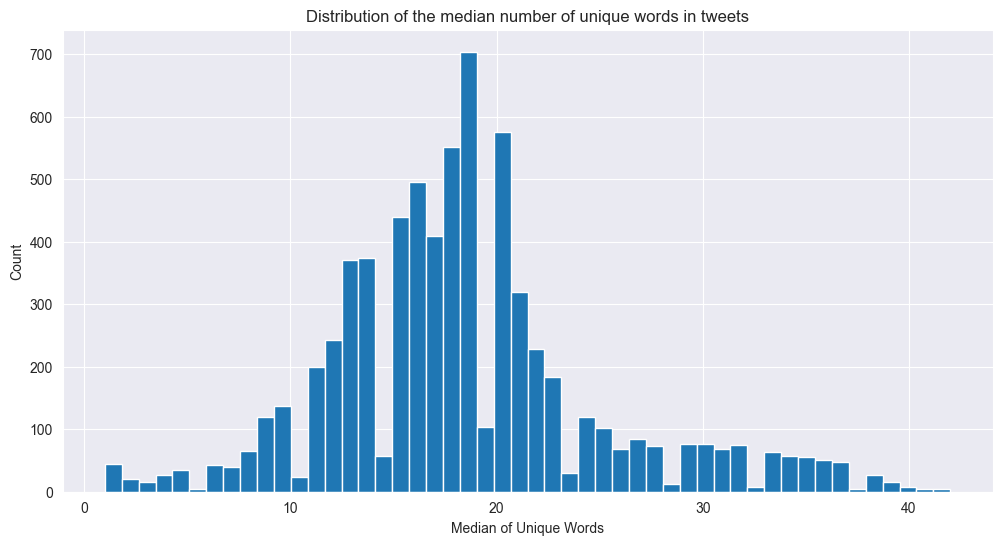

In [37]:
core_users_initiative = core_users.copy()
core_users_tweets_copy = core_users_tweets.copy()

# Rimuove le righe con 'text' vuoto, quindi i retweet
core_users_tweets_copy = core_users_tweets_copy.dropna(subset=['text'])

# Crea una nuova colonna 'unique_words_count' nel DataFrame tweets che conta il numero di parole uniche in ogni tweet
core_users_tweets_copy['unique_words_count'] = core_users_tweets_copy['text'].apply(lambda x: len(np.unique(str(x).split())))

# Raggruppa il DataFrame tweets per 'user_id' e calcola la mediana del numero di parole uniche
unique_words_median = core_users_tweets_copy.groupby('user_id')['unique_words_count'].median()

# Aggiungi la mediana del numero di parole uniche al DataFrame core_users_initiative
core_users_initiative['words_in_tweets_median'] = core_users_initiative.index.map(unique_words_median)

# Stampa un istogramma della mediana del numero di parole uniche
plt.figure(figsize=(12, 6))
plt.hist(core_users_initiative['words_in_tweets_median'].dropna(), bins=50)
plt.xlabel('Median of Unique Words')
plt.ylabel('Count')
plt.title('Distribution of the median number of unique words in tweets')
plt.show()


# Aggiungi la mediana del numero di parole uniche a core_users_to_cluster
core_users_to_cluster['words_in_tweets_median'] = core_users_initiative['words_in_tweets_median']

In [25]:
# Calcola i vari parametri statistici
unique_words_min = tweets.groupby('user_id')['unique_words_count'].min()
unique_words_max = tweets.groupby('user_id')['unique_words_count'].max()
unique_words_mean = tweets.groupby('user_id')['unique_words_count'].mean()
unique_words_std = tweets.groupby('user_id')['unique_words_count'].std()
unique_words_skew = tweets.groupby('user_id')['unique_words_count'].skew()

# Entropia
def entropy(series):
    counts = series.value_counts()
    probabilities = counts / counts.sum()
    return -np.sum(probabilities * np.log2(probabilities))

unique_words_entropy = tweets.groupby('user_id')['unique_words_count'].apply(entropy)

# Aggiungi i parametri al DataFrame core_users_initiative
core_users_initiative['unique_words_min'] = core_users_initiative.index.map(unique_words_min)
core_users_initiative['unique_words_max'] = core_users_initiative.index.map(unique_words_max)
core_users_initiative['unique_words_mean'] = core_users_initiative.index.map(unique_words_mean)
core_users_initiative['unique_words_std'] = core_users_initiative.index.map(unique_words_std)
core_users_initiative['unique_words_skew'] = core_users_initiative.index.map(unique_words_skew)
core_users_initiative['unique_words_entropy'] = core_users_initiative.index.map(unique_words_entropy)

# Aggiungi i parametri a core_users_to_cluster
core_users_to_cluster['unique_words_min'] = core_users_initiative['unique_words_min']
core_users_to_cluster['unique_words_max'] = core_users_initiative['unique_words_max']
core_users_to_cluster['unique_words_mean'] = core_users_initiative['unique_words_mean']
core_users_to_cluster['unique_words_std'] = core_users_initiative['unique_words_std']
core_users_to_cluster['unique_words_skew'] = core_users_initiative['unique_words_skew']
core_users_to_cluster['unique_words_entropy'] = core_users_initiative['unique_words_entropy']


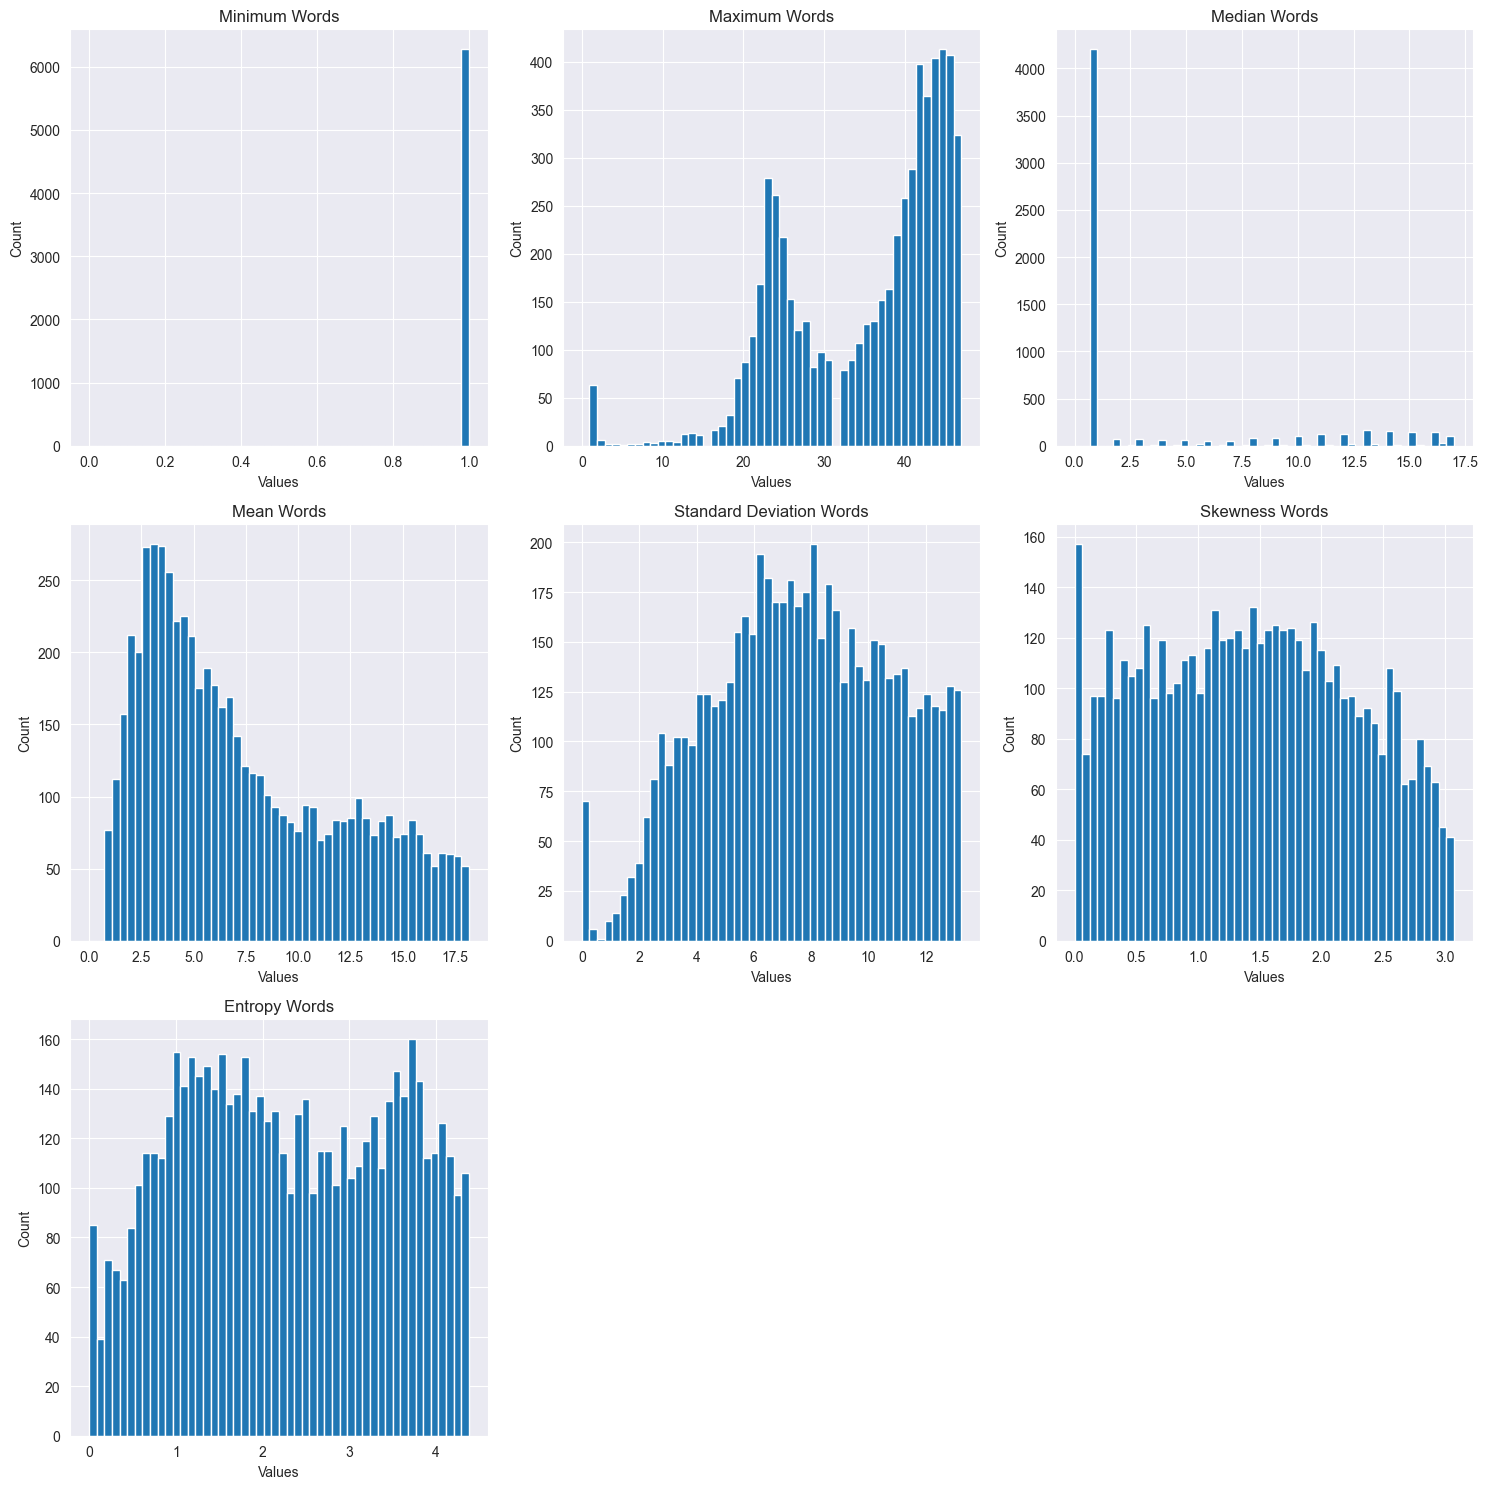

In [26]:
fig, axs = plt.subplots(3, 3, figsize=(15, 15))

# Crea il plot per il minimo
axs[0, 0].hist(core_users_initiative['unique_words_min'].dropna(), bins=50, range=(0, core_users_initiative['unique_words_min'].quantile(0.85)))
axs[0, 0].set_title('Minimum Words')

# Crea il plot per il massimo
axs[0, 1].hist(core_users_initiative['unique_words_max'].dropna(), bins=50, range=(0, core_users_initiative['unique_words_max'].quantile(0.85)))
axs[0, 1].set_title('Maximum Words')

# Crea il plot per la mediana
axs[0, 2].hist(core_users_initiative['words_in_tweets_median'].dropna(), bins=50, range=(0, core_users_initiative['words_in_tweets_median'].quantile(0.85)))
axs[0, 2].set_title('Median Words')

# Crea il plot per la media
axs[1, 0].hist(core_users_initiative['unique_words_mean'].dropna(), bins=50, range=(0, core_users_initiative['unique_words_mean'].quantile(0.85)))
axs[1, 0].set_title('Mean Words')

# Crea il plot per la deviazione standard
axs[1, 1].hist(core_users_initiative['unique_words_std'].dropna(), bins=50, range=(0, core_users_initiative['unique_words_std'].quantile(0.85)))
axs[1, 1].set_title('Standard Deviation Words')

# Crea il plot per la skewness
axs[1, 2].hist(core_users_initiative['unique_words_skew'].dropna(), bins=50, range=(0, core_users_initiative['unique_words_skew'].quantile(0.85)))
axs[1, 2].set_title('Skewness Words')

# Crea il plot per l'entropia
axs[2, 0].hist(core_users_initiative['unique_words_entropy'].dropna(), bins=50, range=(0, core_users_initiative['unique_words_entropy'].quantile(0.85)))
axs[2, 0].set_title('Entropy Words')

# Rimuove gli assi vuoti
for i in range(3):
    for j in range(3):
        axs[i, j].set_xlabel('Values')
        axs[i, j].set_ylabel('Count')

axs[2, 1].axis('off')
axs[2, 2].axis('off')

# Aumenta lo spazio tra i grafici
plt.tight_layout()

plt.show()


### Words entropy in tweets

user_id
841318992094605313     2.843921
1218242063638188033    3.532677
1311952044144685056    2.977085
52021947               3.636855
1298360422433730560    2.864838
Name: avg_entropy, dtype: float64


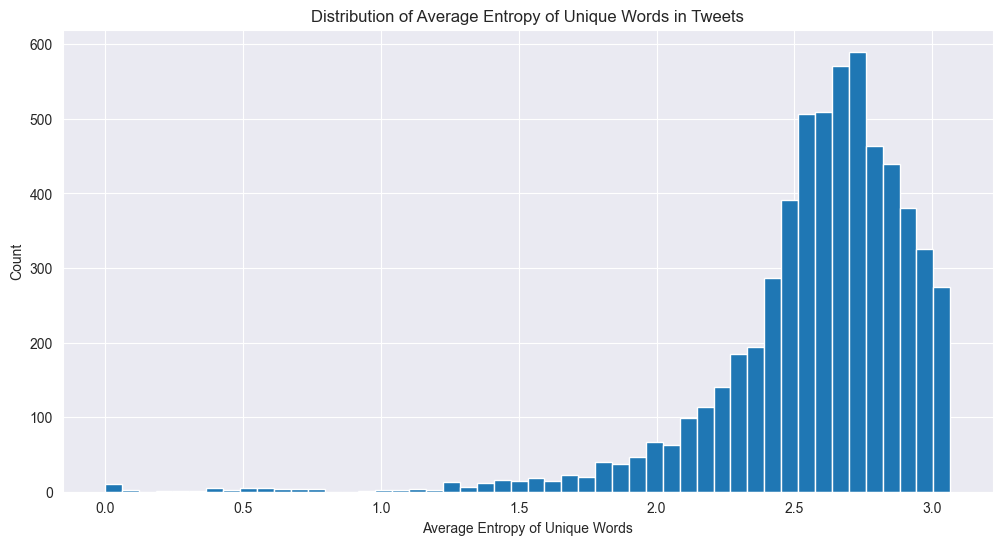

In [38]:
core_users_initiative = core_users.copy()
core_users_tweets_copy = core_users_tweets.copy()

# Rimuove le righe con 'text' vuoto, quindi i retweet
core_users_tweets_copy = core_users_tweets_copy.dropna(subset=['text'])

# Divide ogni tweet in parole uniche
core_users_tweets_copy['unique_words'] = core_users_tweets_copy['text'].astype(str).str.split().apply(set).apply(list)

# Calcola l'entropia per ogni tweet
core_users_tweets_copy['entropy'] = core_users_tweets_copy['unique_words'].apply(lambda x: entropy(pd.Series(x).value_counts()))

# Calcola l'entropia media per ogni utente
entropy_average = core_users_tweets_copy.groupby('user_id')['entropy'].mean()

# Aggiungi la colonna all DataFrame core_users
core_users_initiative['avg_entropy'] = core_users_initiative.index.map(entropy_average)

# Stampa un subset per controllare
print(core_users_initiative['avg_entropy'].head())

plt.figure(figsize=(12, 6))

plt.hist(core_users_initiative['avg_entropy'].replace([np.inf, -np.inf], np.nan).dropna(), bins=50, range=(0, core_users_initiative['avg_entropy'].quantile(0.85)))
plt.xlabel('Average Entropy of Unique Words')
plt.ylabel('Count')
plt.title('Distribution of Average Entropy of Unique Words in Tweets')
plt.show()


core_users_to_cluster['unique_words_entropy'] = core_users_initiative['avg_entropy']

## Adaptability

### Language Novelty

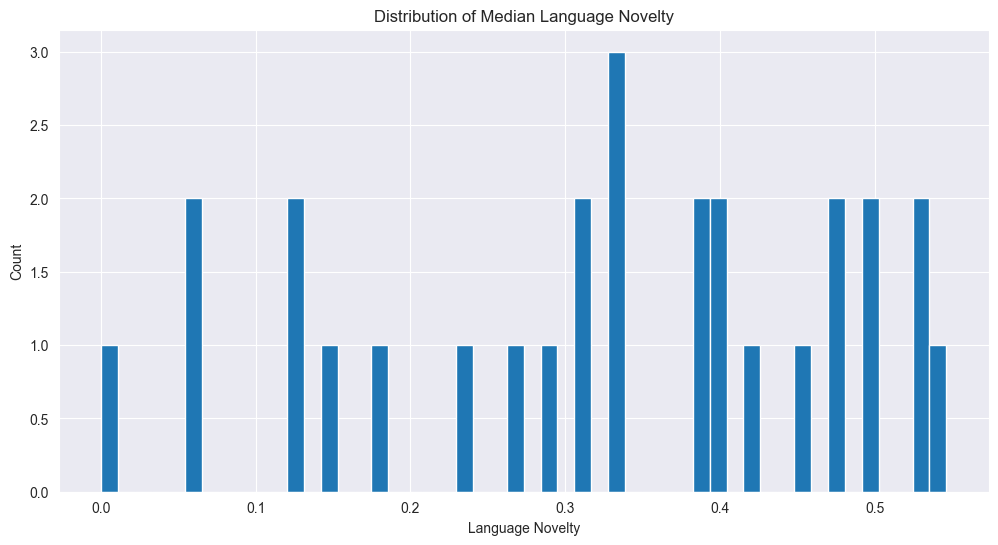

In [39]:
core_users_tweets_copy = core_users_tweets.copy()

# Rimuove le righe con 'text' vuoto, quindi i retweet
core_users_tweets_copy = core_users_tweets_copy.dropna(subset=['text'])

# Ordina tweets per user_id e created_at per garantire l'ordine corretto
core_users_tweets_copy = core_users_tweets_copy.sort_values(['user_id', 'created_at'])

# Creazione di una nuova colonna con i token di ogni tweet
core_users_tweets_copy['tokens'] = core_users_tweets_copy['text'].astype(str).str.split()

# Calcolo dei nuovi token per ogni tweet rispetto al tweet precedente dello stesso utente
def calculate_new_tokens(tokens):
    previous_tokens = set()
    novelty = []

    for token_set in tokens:
        new_tokens = len(set(token_set) - previous_tokens)
        all_tokens = len(set(token_set))

        if all_tokens > 0:
            novelty.append(new_tokens / all_tokens)
        else:
            novelty.append(0)

        previous_tokens = previous_tokens.union(set(token_set))

    return pd.Series(novelty)

core_users_tweets_copy['language_novelty'] = core_users_tweets_copy.groupby('user_id')['tokens'].transform(calculate_new_tokens)

# Ora calcola la mediana della novità del linguaggio per ogni utente
core_users_adaptability['median_language_novelty'] = core_users_tweets_copy.groupby('user_id')['language_novelty'].median()


plt.figure(figsize=(12, 6))

plt.hist(core_users_adaptability['median_language_novelty'].dropna(), bins=50, range=(0, core_users_adaptability['median_language_novelty'].quantile(0.85)))
plt.xlabel('Language Novelty')
plt.ylabel('Count')
plt.title('Distribution of Median Language Novelty')
plt.show()


core_users_to_cluster['language_novelty'] = core_users_adaptability['median_language_novelty']

### Time between tweets

C:\Users\davis\miniconda3\lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,


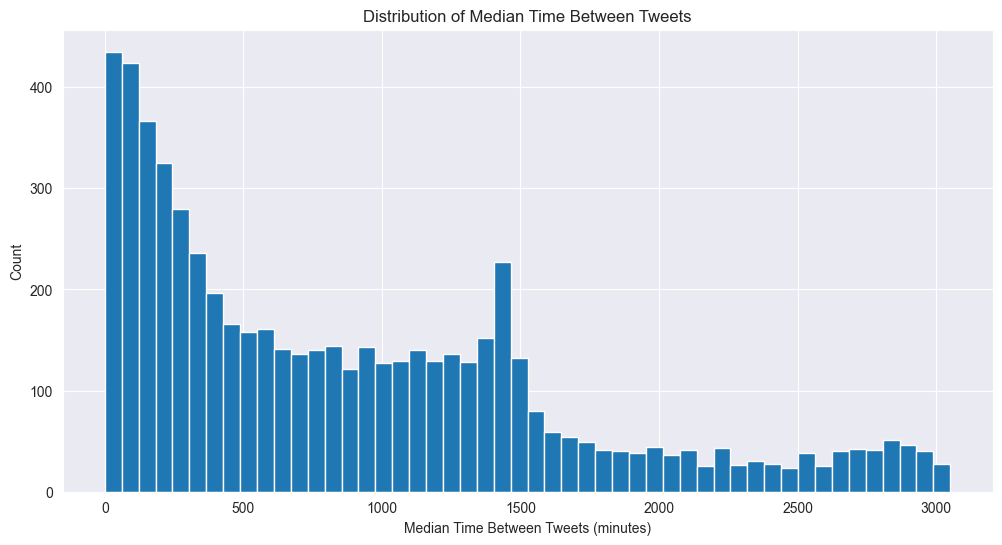

In [40]:
core_users_adaptability = core_users.copy()

# Filtraggio solo i tweet da core_users e non retweet
core_users_tweets_filtered = tweets[(tweets['user_id'].isin(core_users.index)) & (tweets['is_retweet'] == 0)]

# Ordine tweet per core_users e data di creazione
core_users_tweets_sorted = core_users_tweets_filtered.sort_values(by=['user_id', 'created_at'])

# Calcolo della differenza di tempo tra tweet consecutivi per ogni core_users
core_users_tweets_sorted['time_between_tweets'] = core_users_tweets_sorted.groupby('user_id')['created_at'].diff()

# Conversione della differenza di tempo in minuti
core_users_tweets_sorted['time_between_tweets'] = core_users_tweets_sorted['time_between_tweets'].dt.total_seconds() / 60

# Calcola la differenza di tempo tra tweet consecutivi per ogni utente
time_between_tweets_per_user = core_users_tweets_sorted.groupby('user_id')['time_between_tweets'].apply(list)

# Calcola la mediana delle differenze di tempo per ogni utente
median_time_between_tweets = time_between_tweets_per_user.apply(lambda x: np.median([i for i in x if pd.notna(i)]))

# Aggiungi la mediana delle differenze di tempo al DataFrame degli utenti
core_users_adaptability['median_time_between_tweets'] = core_users_adaptability.index.map(median_time_between_tweets)


plt.figure(figsize=(12, 6))

plt.hist(core_users_adaptability['median_time_between_tweets'].dropna(), bins=50, range=(0, core_users_adaptability['median_time_between_tweets'].quantile(0.85)))
plt.xlabel('Median Time Between Tweets (minutes)')
plt.ylabel('Count')
plt.title('Distribution of Median Time Between Tweets')
plt.show()


core_users_to_cluster['median_time_between_tweets'] = core_users_adaptability['median_time_between_tweets']

### Time between retweets

C:\Users\davis\miniconda3\lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,


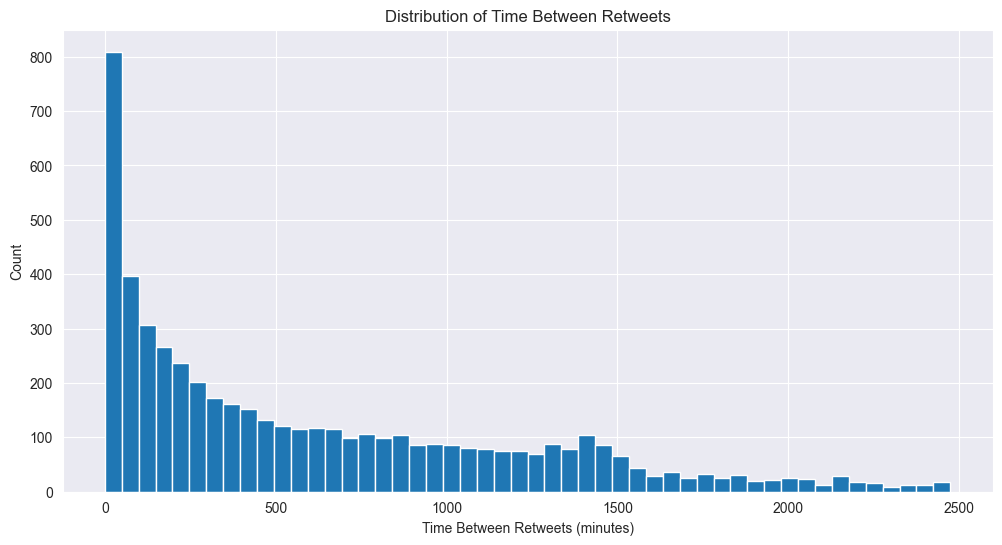

In [41]:
core_users_adaptability = core_users.copy()

# Filtraggio solo i tweet da core_users e non retweet
core_users_retweets = tweets[(tweets['user_id'].isin(core_users.index)) & (tweets['is_retweet'] == 1)]

# Ordine tweet per core_users e data di creazione
core_users_retweets_sorted = core_users_retweets.sort_values(by=['user_id', 'created_at'])

# Calcolo della differenza di tempo tra tweet consecutivi per ogni core_users
core_users_retweets_sorted['time_between_tweets'] = core_users_retweets_sorted.groupby('user_id')['created_at'].diff()

# Conversione della differenza di tempo in minuti
core_users_retweets_sorted['time_between_tweets'] = core_users_retweets_sorted['time_between_tweets'].dt.total_seconds() / 60

# Calcola la differenza di tempo tra retweets consecutivi per ogni utente che ha più di un retweet
time_between_retweets_per_user = core_users_retweets_sorted.groupby('user_id')['time_between_tweets'].apply(list)

# Calcola la mediana delle differenze di tempo per ogni utente, rimuovendo i NaN
median_time_between_retweets = time_between_retweets_per_user.apply(lambda x: np.median([i for i in x if pd.notna(i)]))

# Aggiungi la mediana delle differenze di tempo al DataFrame degli utenti
core_users_adaptability['median_time_between_retweets'] = core_users_adaptability.index.map(median_time_between_retweets)


plt.figure(figsize=(12, 6))

plt.hist(core_users_adaptability['median_time_between_retweets'].dropna(), bins=50, range=(0, core_users_adaptability['median_time_between_retweets'].quantile(0.85)))
plt.xlabel('Time Between Retweets (minutes)')
plt.ylabel('Count')
plt.title('Distribution of Time Between Retweets')
plt.show()


core_users_to_cluster['median_time_between_retweets'] = core_users_adaptability['median_time_between_retweets']

### Time between mentions

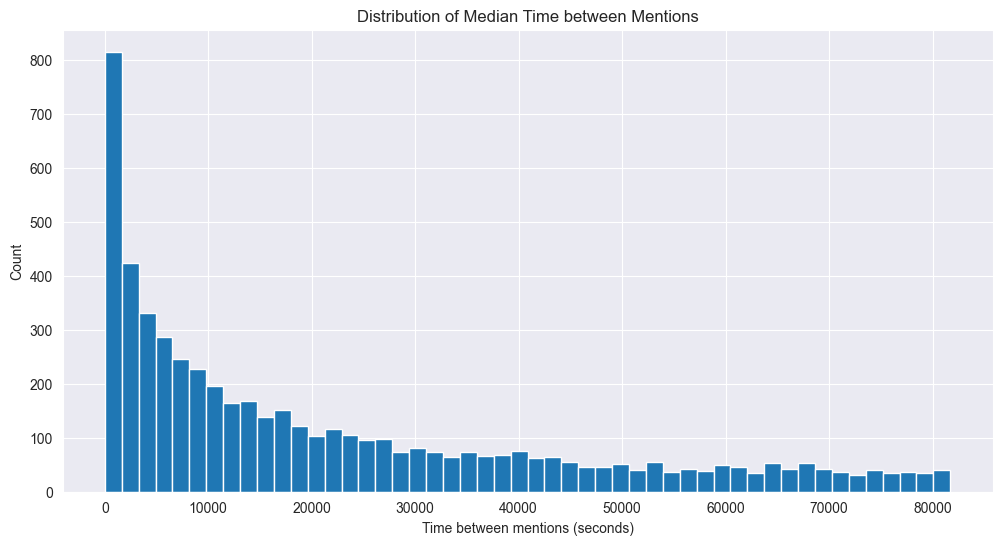

In [42]:
core_users_adaptability = core_users.copy()

# Identifica i tweet che contengono menzioni
tweets_with_mentions = core_users_tweets[core_users_tweets['user_mentions'].notna()]

# Ordina i tweet per utente e data di creazione
tweets_with_mentions = tweets_with_mentions.sort_values(['user_id', 'created_at'])

# Calcola la differenza di tempo tra tweet consecutivi
tweets_with_mentions['time_diff'] = tweets_with_mentions.groupby('user_id')['created_at'].diff()

# Converte la differenza di tempo in secondi
tweets_with_mentions['time_diff_seconds'] = tweets_with_mentions['time_diff'].dt.total_seconds()

# Calcola la mediana del tempo tra menzioni per ogni utente
core_users_adaptability['median_time_between_mentions'] = tweets_with_mentions.groupby('user_id')['time_diff_seconds'].median()


plt.figure(figsize=(12, 6))

plt.hist(core_users_adaptability['median_time_between_mentions'].dropna(), bins=50, range=(0, core_users_adaptability['median_time_between_mentions'].quantile(0.85)))
plt.xlabel('Time between mentions (seconds)')
plt.ylabel('Count')
plt.title('Distribution of Median Time between Mentions')
plt.show()


core_users_to_cluster['median_time_between_mentions'] = core_users_adaptability['median_time_between_mentions']

### Retweeted accounts

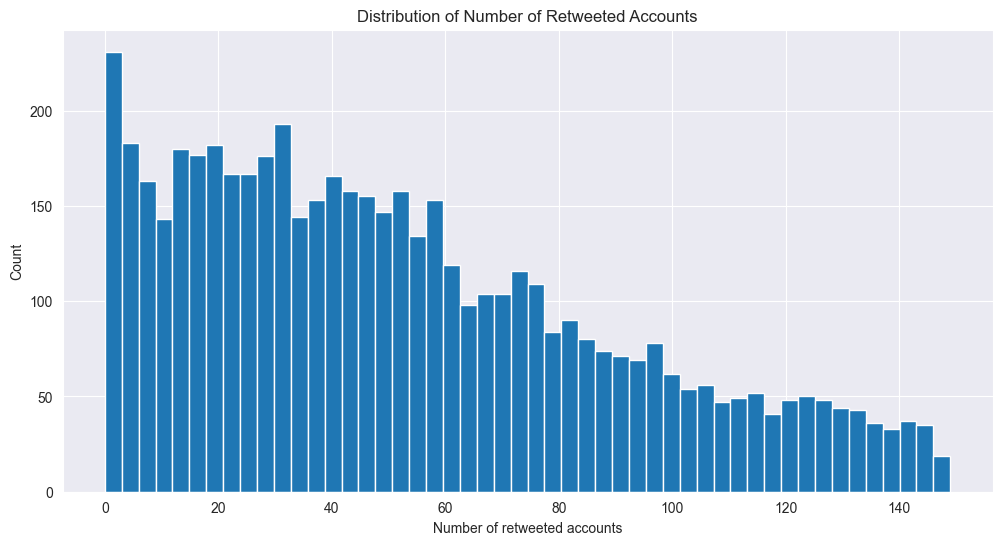

In [43]:
core_users_adaptability = core_users.copy()

# Identifica i tweet che sono stati retweet
retweeted_tweets = core_users_tweets[core_users_tweets['is_retweet'] == 1]

# Calcola il numero di account retwittati per ogni utente
retweeted_accounts = retweeted_tweets.groupby('user_id')['retweeted_user_id'].nunique()

# Aggiunge la colonna 'nbr_retweeted_accounts' a core_users_adaptability
core_users_adaptability['nbr_retweeted_accounts'] = core_users_adaptability.index.map(retweeted_accounts)


plt.figure(figsize=(12, 6))

plt.hist(core_users_adaptability['nbr_retweeted_accounts'].dropna(), bins=50, range=(0, core_users_adaptability['nbr_retweeted_accounts'].quantile(0.85)))
plt.xlabel('Number of retweeted accounts')
plt.ylabel('Count')
plt.title('Distribution of Number of Retweeted Accounts')
plt.show()


core_users_to_cluster['nbr_retweeted_accounts'] = core_users_adaptability['nbr_retweeted_accounts']

### URL domains

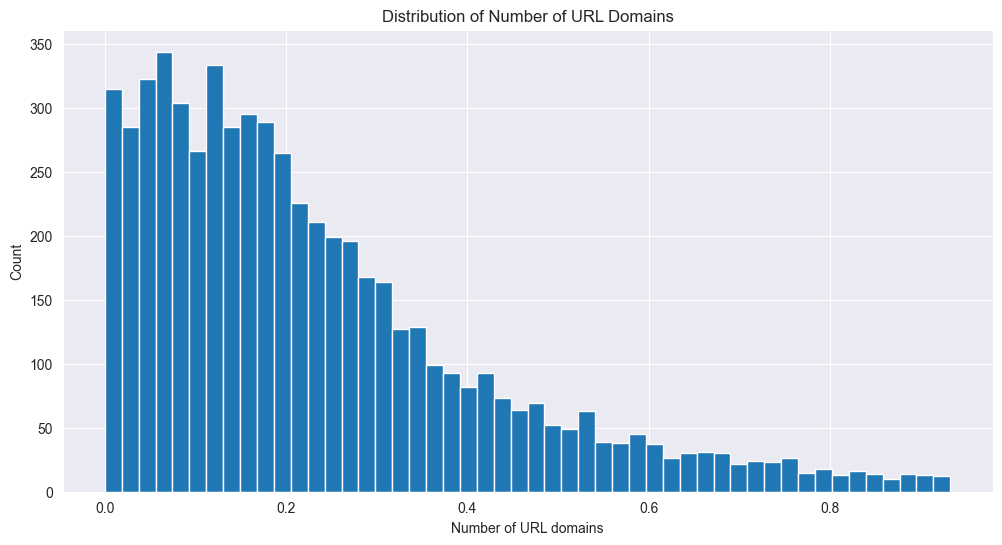

In [44]:
core_users_adaptability = core_users.copy()
core_users_tweets_copy = core_users_tweets.copy()

# Funzione per estrarre il dominio da un URL
def get_domain(url):
    try:
        domain = urlparse(url).netloc
        return domain
    except Exception as e:
        return None

# Divide le stringhe in liste di URL e gestisci i valori null
core_users_tweets_copy['urls'] = core_users_tweets_copy['urls'].apply(lambda x: [] if pd.isna(x) or not isinstance(x, str) else x.split(';'))

# Estrae i domini dagli URL
core_users_tweets_copy['domains'] = core_users_tweets_copy['urls'].apply(lambda urls: [get_domain(url) for url in urls])

# Calcola il numero di domini in ciascun tweet
core_users_tweets_copy['nbr_domains'] = core_users_tweets_copy['domains'].apply(lambda x: len(set(x)))

# Calcola il numero di domini per ogni utente
domain_count_per_user = core_users_tweets_copy.groupby('user_id')['nbr_domains'].apply(list)

# Calcola la mediana del conteggio delle parole per ogni utente
mean_domain_count = domain_count_per_user.apply(np.mean)

# Aggiunge la colonna 'nbr_domains_median' a core_users_adaptability
core_users_adaptability['nbr_domains_mean'] = core_users_adaptability.index.map(mean_domain_count)


plt.figure(figsize=(12, 6))

plt.hist(core_users_adaptability['nbr_domains_mean'].dropna(), bins=50, range=(0, core_users_adaptability['nbr_domains_mean'].quantile(0.85)))
plt.xlabel('Number of URL domains')
plt.ylabel('Count')
plt.title('Distribution of Number of URL Domains')
plt.show()


core_users_to_cluster['nbr_domains_mean'] = core_users_adaptability['nbr_domains_mean']

### Tweets words

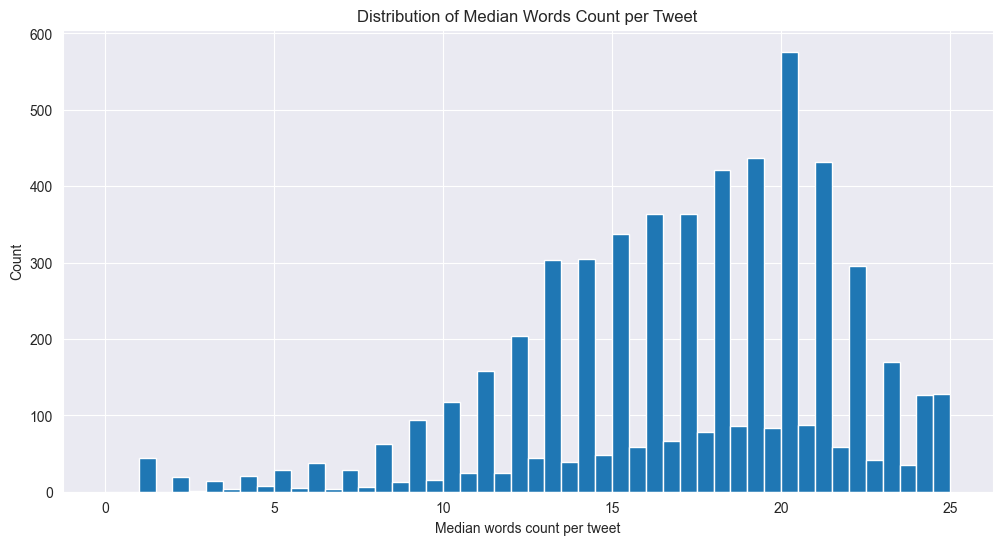

In [45]:
core_users_adaptability = core_users.copy()
core_users_tweets_copy = core_users_tweets.copy()

# Rimuove le righe con 'text' vuoto, quindi i retweet
core_users_tweets_copy = core_users_tweets_copy.dropna(subset=['text'])

# Dividi il testo del tweet in parole e conta il numero di parole
core_users_tweets_copy['words_count'] = core_users_tweets_copy['text'].astype(str).str.split().apply(len)

# Calcola il numero di parole per ogni utente
words_count_per_user = core_users_tweets_copy.groupby('user_id')['words_count'].apply(list)

# Calcola la mediana del conteggio delle parole per ogni utente
median_words_count = words_count_per_user.apply(np.median)

# Aggiungi la mediana del conteggio delle parole al DataFrame degli utenti
core_users_adaptability['median_words_count'] = core_users_adaptability.index.map(median_words_count)


plt.figure(figsize=(12, 6))

plt.hist(core_users_adaptability['median_words_count'].dropna(), bins=50, range=(0, core_users_adaptability['median_words_count'].quantile(0.85)))
plt.xlabel('Median words count per tweet')
plt.ylabel('Count')
plt.title('Distribution of Median Words Count per Tweet')
plt.show()


core_users_to_cluster['median_words_count'] = core_users_adaptability['median_words_count']

### Tweets characters

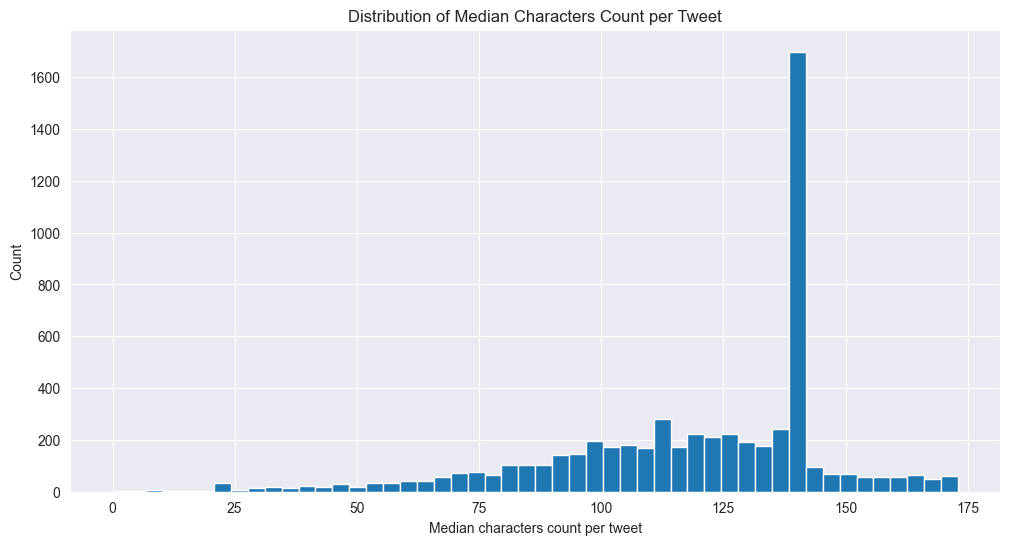

In [46]:
ore_users_adaptability = core_users.copy()
core_users_tweets_copy = core_users_tweets.copy()

# Rimuove le righe con 'text' vuoto, quindi i retweet
core_users_tweets_copy = core_users_tweets_copy.dropna(subset=['text'])

# Calcola il numero di caratteri per ogni tweet
core_users_tweets_copy['char_count'] = core_users_tweets_copy['text'].astype(str).apply(len)

# Calcola il numero di caratteri per ogni utente
char_count_per_user = core_users_tweets_copy.groupby('user_id')['char_count'].apply(list)

# Calcola la mediana del conteggio dei caratteri per ogni utente
median_char_count = char_count_per_user.apply(np.median)

# Aggiungi la mediana del conteggio dei caratteri al DataFrame degli utenti
ore_users_adaptability['median_char_count'] = ore_users_adaptability.index.map(median_char_count)


plt.figure(figsize=(12, 6))

plt.hist(ore_users_adaptability['median_char_count'].dropna(), bins=50, range=(0, ore_users_adaptability['median_char_count'].quantile(0.85)))
plt.xlabel('Median characters count per tweet')
plt.ylabel('Count')
plt.title('Distribution of Median Characters Count per Tweet')
plt.show()


core_users_to_cluster['median_char_count'] = ore_users_adaptability['median_char_count']

## Data Saving

In [47]:
core_users_to_cluster.to_csv('../data/core_users_to_cluster.csv', index=False)